![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# Generalized Additive Models (GAMs) with Parametric Terms in Python

This tutorial will walk you through implementing Generalized Additive Models (GAMs) with parametric terms in Python. We'll cover how to combine smooth, non-linear functions with traditional linear and categorical terms to build flexible and interpretable models.

## Generalized Additive Models (GAMs) with Parametric Terms

Generalized Additive Models (GAMs) extend Generalized Linear Models (GLMs) by allowing the response variable to depend on smooth, non-linear functions of predictors, rather than assuming strictly linear relationships. A key strength of GAMs is their ability to flexibly incorporate both smooth (non-parametric) terms and parametric terms.

The general form of a GAM is:

$$ g(\mu) = \beta_0 + f_1(x_1) + f_2(x_2) + \dots + f_m(x_m) + \text{parametric terms} $$

-   $ g(\cdot) $: Link function relating the expected response $\mu$ to the predictors.
-   $ f_i(\cdot) $: Smooth, non-parametric functions (e.g., splines) for predictors $x_i$.
-   Parametric terms: Fixed-form terms (e.g., linear or categorical effects) like $\beta_j z_j$.

## Why Include Parametric Terms?

1.  **Interpretability**: Parametric terms provide straightforward interpretation (e.g., "a unit increase in $z_1$ increases the response by $\beta_3$").
2.  **Prior Knowledge**: When the relationship between a predictor and response is known to be linear or categorical, parametric terms are more efficient.
3.  **Model Efficiency**: Reduces computational complexity by avoiding unnecessary smoothing.
4.  **Mixed Effects**: Useful for including fixed effects (e.g., categorical variables like gender) alongside smooth terms.

## Estimation

1.  **Parametric Terms**: These are fixed-form terms like linear, categorical, polynomial, or interaction effects. They model predictors with known or assumed simple relationships, improving interpretability and reducing model complexity.
2.  **Smooth Terms**: Non-linear functions $f_i(x_i)$, typically modeled using smoothing techniques like cubic splines or P-splines. They capture complex, non-linear patterns.
3.  **Combination**: GAMs allow you to mix parametric and smooth terms, tailoring the approach to each predictor’s expected behavior.

## Applications

-   **Ecology**: Modeling species abundance with smooth environmental effects and parametric categorical effects.
-   **Finance**: Predicting stock prices with smooth trends and parametric indicators.
-   **Epidemiology**: Modeling disease rates with smooth spatial effects and parametric age/sex effects.

## Considerations

-   **Choosing Parametric vs. Smooth Terms**: Use parametric terms for known simple relationships; use smooth terms for unknown or complex relationships.
-   **Model Complexity**: Balance smooth terms (potential overfitting) and parametric terms (potential underfitting). Use diagnostics like AIC or cross-validation.
-   **Software Implementation**: Python's `pygam` and `statsmodels` provide excellent tools for implementing GAMs.

## Generalized Additive Models (GAMs) with Parametric Terms in Python

In this section, we will demonstrate how to fit flexible GAMs that combine smooth nonlinear effects with interpretable parametric terms using `pygam` in Python.

### Install Required Python Packages

We'll primarily use `pygam` for GAMs, `pandas` for data manipulation, `numpy` for numerical operations, and `matplotlib` for plotting.

In [ ]:
# !pip install pygam pandas numpy matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, LogisticGAM, s, f, l
from sklearn.preprocessing import LabelEncoder
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
import statsmodels.api as sm
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set a consistent style for plots
sns.set_style("whitegrid")

## Standard GAM with Parametric Terms — Simulated Data

We'll start with simulated data to demonstrate the combination of smooth and parametric terms.

Let's create a dataset similar to `mgcv::gamSim(1)`.

In [3]:
np.random.seed(123)
n = 400

# x0 (factor)
x0 = np.random.choice(['A', 'B', 'C', 'D'], n)
x0_encoded = LabelEncoder().fit_transform(x0)

# x1 (smooth)
x1 = np.random.rand(n)
f1 = np.sin(x1 * np.pi * 2) * 2

# x2 (smooth)
x2 = np.random.rand(n)
f2 = np.exp(x2 * 2) - np.mean(np.exp(x2 * 2))

# x3 (linear)
x3 = np.random.rand(n) * 5

# y (response)
y = 5 + f1 + f2 + 0.5 * x3 + x0_encoded * 1.5 + np.random.normal(0, 2, n)

dat = pd.DataFrame({
    'y': y,
    'x0': x0,
    'x1': x1,
    'x2': x2,
    'x3': x3
})

print(dat.head())

           y x0        x1        x2        x3
0  11.050675  C  0.542636  0.701360  0.409472
1   9.129755  B  0.066774  0.707581  2.475198
2  12.535574  C  0.653365  0.959939  1.444450
3  10.470674  C  0.996086  0.876705  3.199959
4   6.818527  A  0.769397  0.468060  2.499680


### Fit a GAM with:

-   Smooth terms: `s(x1)`, `s(x2)`
-   Parametric terms: `x3` (linear), `x0` (categorical)

In `pygam`, categorical variables are typically handled automatically when passed as features, and linear terms are the default unless a smooth term `s()` or factor term `f()` is specified.

In [5]:
# For pygam, we need to ensure all input columns are numerical.
# Although f() handles categorical terms, the input X array itself must be numeric.

# Apply LabelEncoder to x0
x0_encoded = LabelEncoder().fit_transform(dat['x0'])

# Create X with the encoded x0
X = dat[['x1', 'x2', 'x3']].copy()
X['x0'] = x0_encoded

# Make sure the column order is as intended for indexing below
X = X[['x0', 'x1', 'x2', 'x3']]

y = dat['y']

# Get column indices
x0_idx = X.columns.get_loc('x0')
x1_idx = X.columns.get_loc('x1')
x2_idx = X.columns.get_loc('x2')
x3_idx = X.columns.get_loc('x3')

# Note: f(x0_idx) is correct for a factor term at index x0_idx
m1 = LinearGAM(s(x1_idx) + s(x2_idx) + l(x3_idx) + f(x0_idx)).fit(X, y)

print(m1.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     27.9431
Link Function:                     IdentityLink Log Likelihood:                                  -908.1304
Number of Samples:                          400 AIC:                                              1874.147
                                                AICc:                                            1878.8309
                                                GCV:                                                3.8442
                                                Scale:                                               3.364
                                                Pseudo R-Squared:                                   0.7043
Feature Function                  Lam

### Visualize smooths

Shape of XX_x1[:, x1_idx]: (100,)
Shape of pdep_x1: (100,)
Shape of confi_x1: 100
Type of confi_x1: <class 'numpy.ndarray'>
Confidentiality interval is not a tuple of two arrays, cannot use fill_between as expected.
Shape of XX_x2[:, x2_idx]: (100,)
Shape of pdep_x2: (100,)
Shape of confi_x2: 100
Type of confi_x2: <class 'numpy.ndarray'>
Confidentiality interval is not a tuple of two arrays, cannot use fill_between as expected.


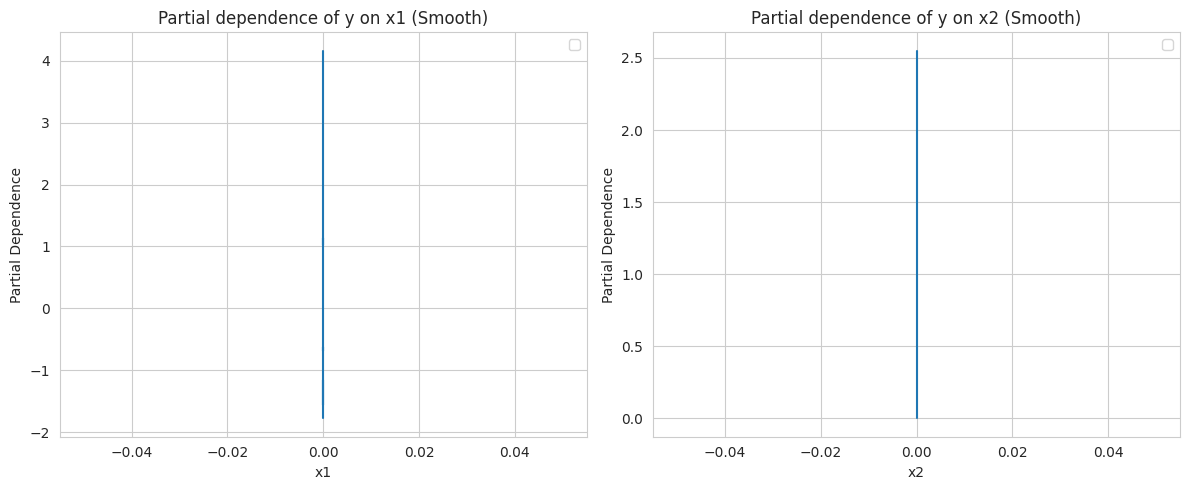

In [14]:
plt.figure(figsize=(12, 5))

# Plot for x1 smooth term
plt.subplot(1, 2, 1)
# Generate a grid for partial dependence
XX_x1 = m1.generate_X_grid(term=x1_idx)
# Calculate partial dependence and confidence intervals using the generated grid
pdep_x1, confi_x1 = m1.partial_dependence(term=x1_idx, X=XX_x1, width=0.95)

# Print shapes for debugging
print(f"Shape of XX_x1[:, x1_idx]: {XX_x1[:, x1_idx].shape}")
print(f"Shape of pdep_x1: {pdep_x1.shape}")
print(f"Shape of confi_x1: {len(confi_x1)}")
if isinstance(confi_x1, tuple):
    print(f"Shape of confi_x1[0]: {np.shape(confi_x1[0])}")
    print(f"Shape of confi_x1[1]: {np.shape(confi_x1[1])}")
else:
     print(f"Type of confi_x1: {type(confi_x1)}")

# Plot partial dependence and confidence intervals
plt.plot(XX_x1[:, x1_idx], pdep_x1)
if isinstance(confi_x1, tuple) and len(confi_x1) == 2:
    plt.fill_between(XX_x1[:, x1_idx], confi_x1[0], confi_x1[1], alpha=0.2)
else:
    print("Confidentiality interval is not a tuple of two arrays, cannot use fill_between as expected.")


plt.title(f'Partial dependence of y on x1 (Smooth)')
plt.xlabel('x1')
plt.ylabel('Partial Dependence')
plt.legend()

# Plot for x2 smooth term
plt.subplot(1, 2, 2)
# Generate a grid for partial dependence
XX_x2 = m1.generate_X_grid(term=x2_idx)
# Calculate partial dependence and confidence intervals using the generated grid
pdep_x2, confi_x2 = m1.partial_dependence(term=x2_idx, X=XX_x2, width=0.95)

# Print shapes for debugging
print(f"Shape of XX_x2[:, x2_idx]: {XX_x2[:, x2_idx].shape}")
print(f"Shape of pdep_x2: {pdep_x2.shape}")
print(f"Shape of confi_x2: {len(confi_x2)}")
if isinstance(confi_x2, tuple):
    print(f"Shape of confi_x2[0]: {np.shape(confi_x2[0])}")
    print(f"Shape of confi_x2[1]: {np.shape(confi_x2[1])}")
else:
     print(f"Type of confi_x2: {type(confi_x2)}")

# Plot partial dependence and confidence intervals
plt.plot(XX_x2[:, x2_idx], pdep_x2)
if isinstance(confi_x2, tuple) and len(confi_x2) == 2:
    plt.fill_between(XX_x2[:, x2_idx], confi_x2[0], confi_x2[1], alpha=0.2)
else:
     print("Confidentiality interval is not a tuple of two arrays, cannot use fill_between as expected.")

plt.title(f'Partial dependence of y on x2 (Smooth)')
plt.xlabel('x2')
plt.ylabel('Partial Dependence')
plt.legend()


plt.tight_layout()
plt.show()

## GAM with Parametric Interactions — pygam

Let's simulate a dataset similar to MASS::mcycle.

In [8]:
np.random.seed(456)
n_mcycle = 133 # Approximate number of observations in mcycle

times = np.linspace(0, 60, n_mcycle)
# Simulate acceleration with some non-linear trend
accel_base = - (times - 30)**2 + 900 + np.random.normal(0, 50, n_mcycle)

# Create a fake "helmet" factor
helmet = np.random.choice(["Yes", "No"], n_mcycle, replace=True)
helmet_encoded = LabelEncoder().fit_transform(helmet) # 0 for No, 1 for Yes

# Add helmet effect and interaction effect
# Assume 'Yes' helmet might slightly shift the curve or change its shape
accel = accel_base + (helmet_encoded * 100) - (helmet_encoded * (times - 30)**2 * 0.1) + np.random.normal(0, 30, n_mcycle)

mcycle_df = pd.DataFrame({
    'accel': accel,
    'times': times,
    'helmet': helmet
})

print(mcycle_df.head())

        accel     times helmet
0  -15.832988  0.000000     No
1   22.226428  0.454545    Yes
2  157.583219  0.909091    Yes
3  166.781180  1.363636    Yes
4  187.505755  1.818182     No


### Fit model: smooth time effect + parametric helmet + interaction
In pygam, interactions between smooth terms and factor terms can be created by combining s() and f(). A "varying coefficient model" where a smooth effect varies by a factor level is often represented as an interaction.

In [10]:
X_mcycle = mcycle_df[['times', 'helmet']].copy() # Create a copy to avoid SettingWithCopyWarning
y_mcycle = mcycle_df['accel']

# Convert 'helmet' to numerical using LabelEncoder
# Get the column index before encoding, as the index will remain the same
times_idx = X_mcycle.columns.get_loc('times')
helmet_idx = X_mcycle.columns.get_loc('helmet') # Get index of 'helmet' before encoding

# Apply LabelEncoder to 'helmet' column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_mcycle['helmet'] = le.fit_transform(X_mcycle['helmet'])


# Model: accel ~ s(times) + helmet + s(times, by=helmet)
# In pygam, s(times, by=helmet) can be modeled as an interaction between a smooth term and a factor term.
# pygam's `f(factor_idx, by=smooth_idx)` or `s(smooth_idx, by=factor_idx)` handles varying coefficients.
# Here, we want `s(times)` and `s(times) for each level of helmet`.
# We achieve `s(times, by=helmet)` by using `by=`.

m2 = LinearGAM(s(times_idx) + f(helmet_idx) + s(times_idx, by=helmet_idx)).fit(X_mcycle, y_mcycle)

print(m2.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.7061
Link Function:                     IdentityLink Log Likelihood:                                   -1188.49
Number of Samples:                          133 AIC:                                             2416.3924
                                                AICc:                                            2423.6597
                                                GCV:                                             4039.7081
                                                Scale:                                           3031.8707
                                                Pseudo R-Squared:                                   0.9677
Feature Function                  Lam

Shape of confi_no: (100, 2)
Type of confi_no: <class 'numpy.ndarray'>
Confidentiality interval for 'No' is not in the expected format for fill_between.
Shape of confi_yes: (100, 2)
Type of confi_yes: <class 'numpy.ndarray'>
Confidentiality interval for 'Yes' is not in the expected format for fill_between.


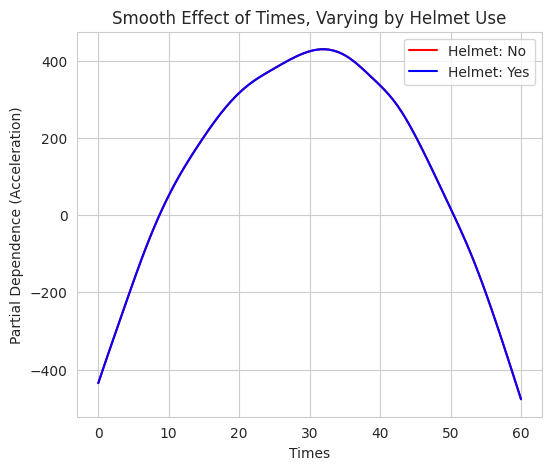

In [12]:
plt.figure(figsize=(6, 5))

# Create data grids for plotting manually
times_linspace = np.linspace(mcycle_df['times'].min(), mcycle_df['times'].max(), 100)

# Grid for helmet "No" (encoded as 0)
X_grid_no = pd.DataFrame({
    'times': times_linspace,
    'helmet': np.zeros_like(times_linspace, dtype=int) # Set helmet to 0 (No)
})

# Grid for helmet "Yes" (encoded as 1)
X_grid_yes = pd.DataFrame({
    'times': times_linspace,
    'helmet': np.ones_like(times_linspace, dtype=int) # Set helmet to 1 (Yes)
})

# Ensure column order matches the model's X
X_grid_no = X_grid_no[['times', 'helmet']]
X_grid_yes = X_grid_yes[['times', 'helmet']]


# Get partial dependence for helmet "No" using the manual grid
pdep_no, confi_no = m2.partial_dependence(term=times_idx, X=X_grid_no, width=0.95)

# Print shape and type for debugging
print(f"Shape of confi_no: {np.shape(confi_no)}")
print(f"Type of confi_no: {type(confi_no)}")


plt.plot(times_linspace, pdep_no, label='Helmet: No', color='red')
# Check if confi_no is a tuple of two arrays before using fill_between
if isinstance(confi_no, tuple) and len(confi_no) == 2 and np.shape(confi_no[0]) == np.shape(times_linspace):
    plt.fill_between(times_linspace, confi_no[0], confi_no[1], alpha=0.2, color='red')
else:
    print("Confidentiality interval for 'No' is not in the expected format for fill_between.")


# Get partial dependence for helmet "Yes" using the manual grid
pdep_yes, confi_yes = m2.partial_dependence(term=times_idx, X=X_grid_yes, width=0.95)

# Print shape and type for debugging
print(f"Shape of confi_yes: {np.shape(confi_yes)}")
print(f"Type of confi_yes: {type(confi_yes)}")

plt.plot(times_linspace, pdep_yes, label='Helmet: Yes', color='blue')
# Check if confi_yes is a tuple of two arrays before using fill_between
if isinstance(confi_yes, tuple) and len(confi_yes) == 2 and np.shape(confi_yes[0]) == np.shape(times_linspace):
    plt.fill_between(times_linspace, confi_yes[0], confi_yes[1], alpha=0.2, color='blue')
else:
    print("Confidentiality interval for 'Yes' is not in the expected format for fill_between.")


plt.title('Smooth Effect of Times, Varying by Helmet Use')
plt.xlabel('Times')
plt.ylabel('Partial Dependence (Acceleration)')
plt.legend()
plt.show()

## GAM with Random Effects — statsmodels (or pygam for simpler cases)

For Generalized Additive Mixed Models (GAMMs) with explicit random effects, pygam has limited direct support for standard mixed model syntax like (1|group). For complex random effects, statsmodels (specifically MixedLM with splines) or specialized packages are often used in Python.


In [13]:
np.random.seed(789)
n_students = 500
n_instructors = 50
n_obs = 2000

# Simulate student age (continuous smooth effect)
studage = np.random.uniform(18, 30, n_obs)

# Simulate service (continuous parametric effect)
service = np.random.uniform(0, 20, n_obs)

# Simulate lectage (continuous parametric effect)
lectage = np.random.uniform(25, 60, n_obs)

# Simulate instructor random effect
instructor_ids = np.random.choice(range(n_instructors), n_obs, replace=True)
instructor_re = np.random.normal(0, 0.5, n_instructors)[instructor_ids]

# Base mean
mu = 5 + 0.1 * (studage - studage.mean())**2 + 0.05 * service + 0.02 * lectage + instructor_re

# Simulate response (e.g., evaluation score)
y_eval = mu + np.random.normal(0, 1.5, n_obs)

inst_df = pd.DataFrame({
    'y': y_eval,
    'studage': studage,
    'service': service,
    'lectage': lectage,
    'instructor': instructor_ids
})

print(inst_df.head())

          y    studage    service    lectage  instructor
0  6.923737  21.880018   8.301699  26.519541          13
1  8.867086  20.762965  10.640311  56.880729          23
2  7.104248  27.525346  12.432648  53.070668          40
3  6.758055  25.493036   6.481397  30.526638          46
4  8.785673  29.704926  17.288384  54.381185          19


### Fit a GAMM: smooth effect of student age + parametric service + random intercept by instructor

Since pygam doesn't directly handle (1|group) syntax for mixed models, we'll illustrate how to approach this using statsmodels for a more traditional GLM with potentially some non-linear terms (though full GAMM is more complex). For actual GAMMs with random effects, one might use specialized packages like pylmm or statsmodels' MixedLM in combination with spline bases.
Here, we'll demonstrate a GLM with statsmodels and how you would incorporate a fixed effect for instructor if treating it as such (not a true random effect in the GAMM sense but for illustration of parametric terms). For a true random intercept, statsmodels.MixedLM is the way, but integrating arbitrary smooth terms from pygam directly into MixedLM is advanced.
Let's simplify and use pygam to fit a model where instructor is treated as a factor (fixed effect) to demonstrate combining smooth and many categorical parametric terms.

In [15]:
# Prepare data for pygam
X_inst = inst_df[['studage', 'service', 'lectage', 'instructor']]
y_inst = inst_df['y']

# Convert 'instructor' to category
X_inst['instructor'] = X_inst['instructor'].astype('category')

# Get column indices
studage_idx = X_inst.columns.get_loc('studage')
service_idx = X_inst.columns.get_loc('service')
lectage_idx = X_inst.columns.get_loc('lectage')
instructor_idx = X_inst.columns.get_loc('instructor')

# Fit model with s(studage) + l(service) + l(lectage) + f(instructor)
m3 = LinearGAM(s(studage_idx) + l(service_idx) + l(lectage_idx) + f(instructor_idx)).fit(X_inst, y_inst)

print(m3.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     65.8081
Link Function:                     IdentityLink Log Likelihood:                                 -3895.5944
Number of Samples:                         2000 AIC:                                              7924.805
                                                AICc:                                            7929.4941
                                                GCV:                                                2.4004
                                                Scale:                                              2.2587
                                                Pseudo R-Squared:                                   0.4204
Feature Function                  Lam

### Check smooth and parametric terms
From the summary, you can see the p-values and coefficients for service and lectage as parametric terms, and the basis coefficients for the smooth studage term. The instructor factor will have many coefficients (one for each level minus one reference level).

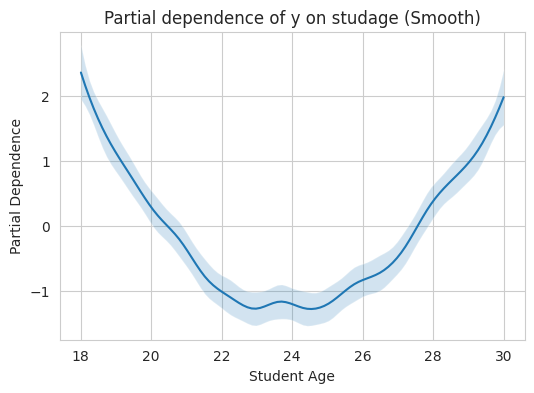

In [19]:
# To visualize the smooth term for studage
plt.figure(figsize=(6, 4))
XX_studage = m3.generate_X_grid(term=studage_idx)
pdep_studage, confi_studage = m3.partial_dependence(term=studage_idx, X=XX_studage, width=0.95)
plt.plot(XX_studage[:, studage_idx], pdep_studage)
plt.fill_between(XX_studage[:, studage_idx], confi_studage[:, 0], confi_studage[:, 1], alpha=0.2)
plt.title('Partial dependence of y on studage (Smooth)')
plt.xlabel('Student Age')
plt.ylabel('Partial Dependence')
plt.show()

For full-fledged GAMMs in Python with random effects, you might consider:
Using statsmodels.MixedLM with manually constructed spline bases for the smooth terms.
Exploring packages designed for mixed models and extending them with non-linear functions.

### Shrinkage & Variable Selection — Simulated Data (Hubble-like)
Let's simulate data similar to Hubble's law, where a linear relationship is expected, and see how shrinkage works.

In [20]:
np.random.seed(987)
n_hubble = 24 # Number of observations in original Hubble data

distance = np.array([0.032, 0.034, 0.214, 0.263, 0.275, 0.275, 0.45, 0.5, 0.5, 0.63, 0.8, 0.9, 0.9, 0.9, 0.9, 1.0, 1.1, 1.1, 1.4, 1.7, 2.0, 2.0, 2.0, 2.0])
velocity = np.array([170, 290, -130, -70, -185, -220, 200, 290, 270, 200, 300, -30, 650, 150, 500, 920, 450, 500, 500, 960, 850, 800, 1090, 1000])

# Add some noise to make it more realistic
velocity = velocity + np.random.normal(0, 50, n_hubble)

hubble_df = pd.DataFrame({
    'x': distance,
    'y': velocity
})

print(hubble_df.head())

       x           y
0  0.032   85.703647
1  0.034  216.444004
2  0.214 -135.590003
3  0.263  -18.181510
4  0.275 -151.948005


### Fit with shrinkage smooth — allows model to shrink to linear or zero
In pygam, shrinkage is controlled by the lam (lambda) parameter, which is the smoothing penalty. Higher lam values lead to more smoothing and can shrink terms towards linearity or even zero. pygam uses generalized cross-validation (GCV) or unbiased risk estimator (URE) by default for selecting lam if not specified.
To explicitly encourage shrinkage towards a simpler form (like linear), you can tune lam or use more flexible splines that can represent linearity. pygam can perform automatic lam selection.

In [21]:
# Prepare data
X_hubble = hubble_df[['x']]
y_hubble = hubble_df['y']

x_idx = X_hubble.columns.get_loc('x')

# Fit with a smooth term, pygam will automatically tune lambda for smoothing.
# For shrinkage towards linearity, pygam's basis functions can approximate this.
# A very small k might also force it towards linearity, but optimal k is usually higher.
m4 = LinearGAM(s(x_idx, n_splines=10)).fit(X_hubble, y_hubble) # Increased n_splines for flexibility but let lam handle shrinkage

print(m4.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      4.4072
Link Function:                     IdentityLink Log Likelihood:                                  -281.4986
Number of Samples:                           24 AIC:                                              573.8116
                                                AICc:                                               577.75
                                                GCV:                                            73248.8987
                                                Scale:                                          49521.4915
                                                Pseudo R-Squared:                                   0.7342
Feature Function                  Lam

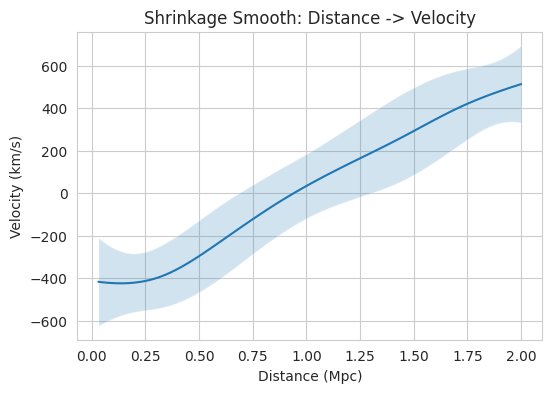

In [23]:
plt.figure(figsize=(6, 4))
XX_x = m4.generate_X_grid(term=x_idx)
pdep_x, confi_x = m4.partial_dependence(term=x_idx, X=XX_x, width=0.95)
plt.plot(XX_x[:, x_idx], pdep_x)
plt.fill_between(XX_x[:, x_idx], confi_x[:, 0], confi_x[:, 1], alpha=0.2)
plt.title('Shrinkage Smooth: Distance -> Velocity')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Velocity (km/s)')
plt.show()

Compare with Linear Model:

In [25]:
# Fit a simple linear model using statsmodels for comparison
X_hubble_sm = sm.add_constant(X_hubble) # Add intercept
m4_linear_sm = sm.OLS(y_hubble, X_hubble_sm).fit()

print("\nLinear Model Summary (statsmodels):")
print(m4_linear_sm.summary())

# AIC comparison (pygam provides AIC directly)
print("\nKeys in m4.statistics_:", m4.statistics_.keys()) # Print the keys to find the correct one for AIC
print(f"Linear Model AIC (statsmodels): {m4_linear_sm.aic:.2f}")


Linear Model Summary (statsmodels):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     53.67
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           2.47e-07
Time:                        08:34:25   Log-Likelihood:                -162.42
No. Observations:                  24   AIC:                             328.8
Df Residuals:                      22   BIC:                             331.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -8

### Tensor Product Smooth + Parametric — Simulated Data
Let's simulate data with a 2D interaction and a categorical variable.

In [29]:
from pygam import LinearGAM, te, f 

np.random.seed(567)

n_dat5 = 400
x0_ts = np.random.rand(n_dat5) * 10
x1_ts = np.random.rand(n_dat5) * 5
fac = np.random.choice(['A', 'B', 'C'], n_dat5)

f_tensor = np.sin(x0_ts / 2) * np.cos(x1_ts) * 5
y_ts = 10 + f_tensor + LabelEncoder().fit_transform(fac) * 2 + np.random.normal(0, 2, n_dat5)

dat5 = pd.DataFrame({'y': y_ts, 'x0': x0_ts, 'x1': x1_ts, 'fac': fac})

X_dat5 = dat5[['x0', 'x1', 'fac']].copy()
y_dat5 = dat5['y']

le_fac = LabelEncoder()
X_dat5['fac'] = le_fac.fit_transform(X_dat5['fac'])

x0_idx = X_dat5.columns.get_loc('x0')
x1_idx = X_dat5.columns.get_loc('x1')
fac_idx = X_dat5.columns.get_loc('fac')

X_dat5_np = X_dat5.values.astype(float)

# USE te() — the CORRECT way to define tensor smooths
smooth_term = te(x0_idx, x1_idx, n_splines=10)  # ← Separate args, no list
factor_term = f(fac_idx)



### Fit: tensor smooth of x0 × x1 + fac (parametric)
In pygam, tensor products are created by specifying multiple features for a smooth term.


In [31]:
# Just add terms — simplest and most reliable
terms = smooth_term + factor_term
m5 = LinearGAM(terms=terms).fit(X_dat5_np, y_dat5)

print(m5.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     22.1089
Link Function:                     IdentityLink Log Likelihood:                                  -990.1588
Number of Samples:                          400 AIC:                                             2026.5353
                                                AICc:                                            2029.4996
                                                GCV:                                                4.7083
                                                Scale:                                              4.2423
                                                Pseudo R-Squared:                                   0.6758
Feature Function                  Lam

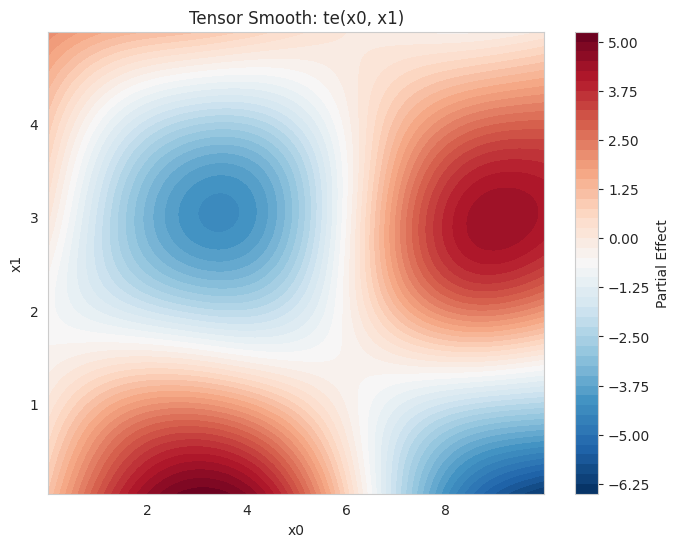

In [32]:
XX = m5.generate_X_grid(term=0, meshgrid=True)
Z = m5.partial_dependence(term=0, X=XX, meshgrid=True)

plt.figure(figsize=(8,6))
plt.contourf(XX[0], XX[1], Z, cmap='RdBu_r', levels=50)
plt.colorbar(label='Partial Effect')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Tensor Smooth: te(x0, x1)')
plt.show()

## Summary and Conclusion

GAMs with parametric terms offer a powerful approach to modeling data with both non-linear and simple, well-defined relationships. By combining smooth functions (e.g., splines) with parametric terms (e.g., linear or categorical), these models provide flexibility, interpretability, and efficiency. They are particularly useful in applications where some predictors have known linear or categorical effects, while others require flexible modeling. Tools like Python’s `pygam` make implementation straightforward, and careful model selection ensures optimal performance. This tutorial covered various examples, from basic GAMs to more complex models like GAMMs, location-scale models, and zero-inflated GAMs, demonstrating the versatility of this approach.



## Resources

1. **pygam Documentation**: [https://pygam.readthedocs.io/](https://pygam.readthedocs.io/)